In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
tempStat = pd.read_csv('drive/MyDrive/data/Temperature statistics.csv')
netDet = pd.read_csv('drive/MyDrive/data/Network deterioration.csv')
natInci = pd.read_csv('drive/MyDrive/data/Natural incidents.csv')
meteo = pd.read_csv('drive/MyDrive/data/Meteo data.csv')

meteToReg = pd.read_csv('drive/MyDrive/data/Meteo data. MO and meteo accordance.csv')


<ipython-input-108-08af9ad9958b>:4: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  meteo = pd.read_csv('drive/MyDrive/data/Meteo data.csv')


## Метеоданные

In [144]:
natInci.columns =['time', 'reg', 'accept', 'ny', 'type', 'criteri','character','outcome']
natInci.accept = natInci.accept.fillna('-')

In [148]:
natInci.criteri.unique()

array([' Сильный мороз', ' Очень сильный снег , Сильная метель',
       ' Очень сильный ветер , Очень сильный снег , Сильная метель', nan,
       ' Очень сильный ветер',
       ' Очень сильный ветер , Очень сильный снег',
       ' Аномально холодная погода', ' Чрезвычайная пожарная опасность',
       ' Заморозки', ' Аномально жаркая погода', ' Сильная жара',
       ' Ураганный ветер(ураган) , Очень сильный дождь',
       ' Шквал , Очень сильный дождь , Крупный град , Аномально жаркая погода',
       ' Очень сильный дождь',
       ' Очень сильный ветер , Очень сильный дождь , Крупный град',
       ' Град, ливень, сильный дождь, сильный ветер',
       ' Сильная жара , Аномально жаркая погода',
       ' Очень сильный ветер , Шквал , Очень сильный дождь , Сильный ливень',
       ' Очень сильный ветер , Очень сильный дождь',
       ' Очень сильный ветер , Сильная метель',
       ' Сильное гололедно-изморозевое отложение на проводах',
       ' Гололед, налипание мокрого снега при сильном вет

In [ ]:

# meteo.groupby([pd.Grouper(key='time', freq='D'), meteo.meteostation])['Местное время'].count()

## Целевые признаки

In [109]:
dtp = pd.read_csv('drive/MyDrive/data/DTP.csv')
fires = pd.read_csv('drive/MyDrive/data/Fires.csv')
incidents = pd.read_csv('drive/MyDrive/data/Incidents.csv')
dtp.columns = ['reg', 'type','time', 'reason']
incidents.columns = ['reg','type', 'time']
fires.columns = ['reg', 'type','time', 'reason']
lmap = {
        'Кизел ГО':'ГО город Кизел',
        'Кизеловский ГО': 'ГО город Кизел',
        'Нытвенский  ГО': 'Нытвенский ГО',
        'Березники ГО': 'ГО город Березники',
        'Губахинский ГО': 'Губахинский МО',
        'Верещагино ГО': 'Верещагинский ГО',
        'Гремячинск ГО':'Губахинский МО',
        'Пермский край': '',
 }

dtp = dtp.dropna()[dtp.dropna().reason.apply(lambda x: 'пдд' not in x.lower())] # убрать нарушение пдд и дтп без указания причины
fires = fires[fires['reason'].apply(lambda x: 'НППБ' not in x)] # убрать пожары где прична была НППБ
emergency = pd.concat([dtp, fires])
del dtp, fires
emergency.drop('reason', axis=1, inplace=True)
emergency = pd.concat([emergency, incidents])

emergency.reg = emergency.reg.apply(lambda x: x.strip())
emergency.reg = emergency.reg.map(lmap).fillna(emergency.reg)
emergency.drop(index=emergency[emergency.reg.isin([''])].index, inplace=True)

import re
def selection(tipe:str)-> str:
  nature = ['заморозки', 'туман','дождь','сильный ветер','просадка', 'абразия', "паводок", "снег", "оползни", "засуха", 'половодье']
  toxic = ['нефте', "АХОВ", "загрязнения"]
  blows = ['пожар', 'взрыв']
  roadTP = ['дтп', 'перерыв в движении', 'транспорт', "аэропорт", "пассажир"]
  GKH = ['канализац', "электроэнергетич", "коммунальн", "питьевой"]

  if re.search(str.join('|', roadTP), tipe.lower().strip()):
    return 'Аварии на транспорте'
  if re.search(str.join('|', toxic), tipe.lower().strip()):
    return 'Аварии с выбросом опасных/токсичных веществ'
  if re.search(str.join('|', nature), tipe.lower().strip()):
    return 'Опасные природные явления'
  if re.search(str.join('|', GKH), tipe.lower().strip()):
    return 'ЖКХ'
  if re.search(str.join('|', blows), tipe.lower().strip()):
    return 'Взрывы/пожары/разрушения'


  return 'Прочие опасности'
emergency['type'] = emergency['type'].apply(lambda x: selection(x))
emergency = emergency.reset_index().drop('index', axis=1)
emergency.time = pd.to_datetime(emergency.time, errors='coerce')
emergency.dropna(inplace=True)
emergency.time = pd.to_datetime(emergency.time.dt.strftime('%Y-%m-%d'))  # merge вот эту  табличка

In [ ]:
emergency.groupby([pd.Grouper(key='time', freq='D'),  emergency.reg])['type'].count().value_counts().sort_index(ascending=False)

314      1
284      1
281      1
242      1
237      2
      ... 
5      391
4      485
3      595
2      580
1      477
Name: type, Length: 146, dtype: int64

In [137]:
emergency.reg.unique()

43

In [110]:
tempStat = pd.read_csv('drive/MyDrive/data/Temperature statistics.csv')
tempStat = tempStat[~tempStat.year.isin(['среднемноголетняя температура'])]
tempStat = tempStat.dropna()
monthRus = {
    'январь':1,
    'ферваль':2,
    'март':3,
    'апрель':4,
    'май':5,
    'июнь':6,
    'июль':7,
    'август':8,
    'сентябрь':9,
    'октябрь':10,
    'ноябрь':11,
    'декабрь':12
}
tempStat.month = tempStat.month.map(monthRus)
tempStat['time'] = pd.to_datetime(tempStat.year+"-"+tempStat.month.astype('string')+"-"+tempStat.day.astype('string'))

In [111]:
meteo.rename(columns={'Местное время':'time'}, inplace=True)
meteo.time = pd.to_datetime(meteo.time)
snow_map={
    'Снежный покров не постоянный.': 0,
    'Менее 0.5': 0,
    'Измерение невозможно или неточно.':0,
}
meteo.sss = meteo.sss.map(snow_map).fillna(meteo.sss).fillna(0).astype('int')

In [112]:
meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569516 entries, 0 to 569515
Data columns (total 30 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   time          569516 non-null  datetime64[ns]
 1   T             569198 non-null  float64       
 2   Po            568966 non-null  float64       
 3   P             568776 non-null  float64       
 4   Pa            295447 non-null  float64       
 5   U             568919 non-null  float64       
 6   DD            560678 non-null  object        
 7   Ff            560733 non-null  float64       
 8   ff10          21459 non-null   float64       
 9   ff3           69478 non-null   float64       
 10  N             546045 non-null  object        
 11  WW            569516 non-null  object        
 12  W1            236966 non-null  object        
 13  W2            236956 non-null  object        
 14  Tn            86899 non-null   float64       
 15  Tx            697

In [126]:
col_to_drop = ['DD', 'N', 'WW', 'W1', 'W2', 'Cl', 'Nh', 'H', 'Cm', 'Ch', 'VV', 'RRR', 'E', "E\'"]
meteo.drop(col_to_drop, axis=1, inplace=True)

In [128]:
meteo.isna().fillna()

time                 0
T                  318
Po                 550
P                  740
Pa              274069
U                  597
Ff                8783
ff10            548057
ff3             500038
Tn              482617
Tx              499789
Td                 406
tR              430189
Tg              535195
sss                  0
meteostation         0
dtype: int64

In [ ]:

meteo.loc[np.random.randint(0, len(meteo), 20)]

In [113]:

meteo.meteostation.unique()

array(['Оса', 'Кочево', 'Большая Соснова', 'Оханск', 'Чермоз', 'Кын',
       'Кудымкар', 'Чердынь', 'Коса', 'Чайковский', 'Ножовка', 'Вая',
       'Чернушка', 'Лысьва', 'Октябрьский', 'Пермь', 'Усть-Черная ',
       'Кунгур', 'Верещагино', 'Гайны', 'Березники', 'Бисер', 'Губаха',
       'Добрянка'], dtype=object)

In [134]:
meteo.groupby([meteo.meteostation, pd.Grouper(key='time', freq='D')]).agg(['mean', 'std']).transform(lambda val: val.fillna(val.median())).reset_index() # вот эту табличка

meteostation       time          T                    Po            \
                                    mean       std        mean       std   
0        Березники 2013-01-01 -18.762500  1.522158  745.675000  1.500238   
1        Березники 2013-01-02  -9.950000  3.352611  746.375000  1.575482   
2        Березники 2013-01-03 -22.887500  6.902264  734.387500  1.636580   
3        Березники 2013-01-04  -2.587500  1.498034  750.862500  2.088019   
4        Березники 2013-01-05   4.414286  2.043223  741.071429  2.825311   
...            ...        ...        ...       ...         ...       ...   
73906     Чернушка 2022-12-27  -9.375000  1.683322  758.862500  0.266927   
73907     Чернушка 2022-12-28 -13.200000  2.682217  757.212500  0.835699   
73908     Чернушка 2022-12-29 -16.600000  4.327982  755.012500  0.839111   
73909     Чернушка 2022-12-30 -11.287500  0.953846  754.400000  0.759699   
73910     Чернушка 2022-12-31 -15.625000  2.125861  756.500000  0.459814   

              P                      Pa            ...    Tx              Td  \
           mean       std          mean       std  ...  mean  std       mean   
0      763.6375  1.570202 -6.938894e-18  0.477344  ... -18.1  0.0 -20.800000   
1      763.6500  1.819733 -6.938894e-18  0.477344  ...  -5.5  0.0 -14.812500   
2      752.3875  1.323888  5.125000e-01  0.496955  ... -14.0  0.0 -29.200000   
3      767.8750  2.157214  3.750000e-01  1.049830  ...   1.6  0.0  -4.087500   
4      757.4000  2.879815 -1.250000e+00  1.561730  ...   5.7  0.0  -0.014286   
...         ...       ...           ...       ...  ...   ...  ...        ...   
73906  773.5500  0.329502 -6.938894e-18  0.477344  ...  -8.4  0.0 -12.037500   
73907  772.1125  0.683348 -6.938894e-18  0.477344  ... -11.7  0.0 -15.512500   
73908  770.0750  1.108087 -6.938894e-18  0.477344  ... -11.8  0.0 -19.375000   
73909  769.1625  0.765203 -6.938894e-18  0.477344  ...  -9.1  0.0 -13.600000   
73910  771.5000  0.427618 -6.938894e-18  0.477344  ... -14.2  0.0 -18.362500   

                   tR        Tg         sss             
            std  mean  std mean  std   mean        std  
0      1.527837  12.0  0.0  8.0  0.0  4.000  11.313708  
1      1.539422  12.0  0.0  8.0  0.0  7.375  20.859650  
2      3.698262  12.0  0.0  8.0  0.0  7.500  21.213203  
3      0.662112  12.0  0.0  8.0  0.0  9.250  26.162951  
4      4.645223  12.0  0.0  8.0  0.0  0.000   0.000000  
...         ...   ...  ...  ...  ...    ...        ...  
73906  1.387637  12.0  0.0  8.0  0.0  3.125   8.838835  
73907  2.866276  12.0  0.0  8.0  0.0  3.125   8.838835  
73908  4.526667  12.0  0.0  8.0  0.0  3.125   8.838835  
73909  0.939605  12.0  0.0  8.0  0.0  3.125   8.838835  
73910  2.292807  12.0  0.0  8.0  0.0  3.375   9.545942  

[73911 rows x 30 columns]

In [ ]:
netDet.columns = ['reg', 'heat_supply','cold_water','hot_water','electricy','gas','water_cooking', 'water_pump', 'water_take', 'water_out', 'water_clear','sewage_pump', 'warm_engines', 'warm_points']

In [ ]:
netDet.sort_values('reg')

Очевидно надо разделить на нормальные причины

## Евгений
надо смержить
emergency <-> metetoreg <-> meteo

### Станции и их регионы

In [ ]:
meteToReg.columns = ['reg', 'station']
meteToReg.reg = meteToReg.reg.apply(lambda x: x.strip())


In [ ]:
np.setdiff1d(emergency.reg.unique(), meteToReg.reg)

array([], dtype=object)

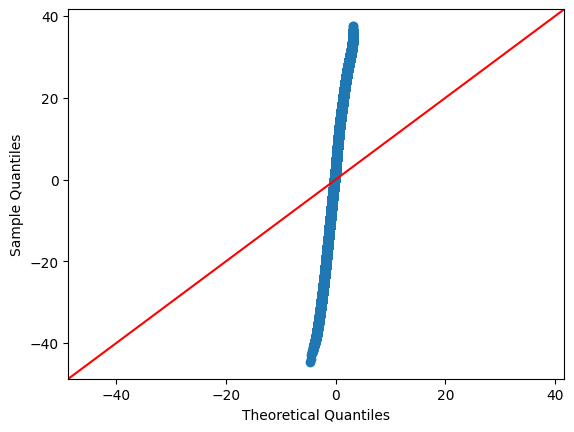

In [ ]:
import statsmodels.api as sm
fig = sm.qqplot(meteo['T'], line='45')
plt.show()